In [1]:
from PreprocessingDataset import Preprocessing_Data as pp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')
# disply all columns
pd.set_option('display.max_columns', None)

In [2]:
bank = pd.read_csv('Churn_Modelling.csv').drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
# Exited : Churned or not? (0=No,1=Yes)

### Overall

In [3]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Nulls

In [4]:
pp.detected_null_value(bank, presentage_of_null=0)

,index,Counter,presentage of null value


### Split Categorical vs Numerical

In [5]:
bank_num, bank_cat= pp.separate_data(bank)

### Distribution

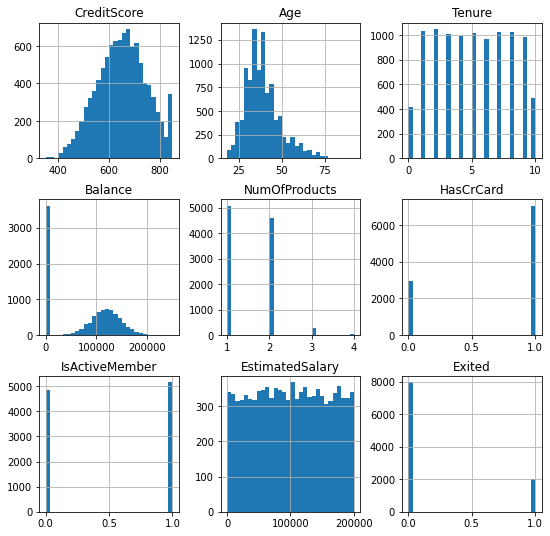

In [6]:
pp.histplot(bank_num)

In [7]:
binary_col = ['HasCrCard', 'IsActiveMember', 'Exited', 'NumOfProducts']
non_binary_col = ['CreditScore','Age', 'Tenure','Balance', 'EstimatedSalary']

### Outliers

In [8]:
bank_num[non_binary_col] = pp.detected_outliers(bank_num[non_binary_col], threshold=1.5, clampping=True)

dropped outliers in column:  CreditScore
- outliers in column:  CreditScore
dropped outliers in column:  Age
- outliers in column:  Age


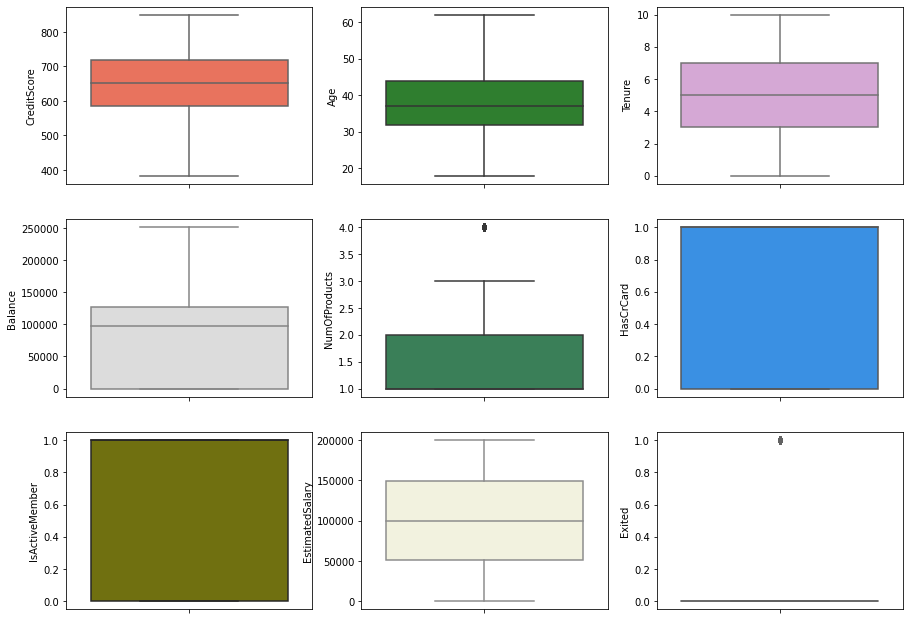

In [9]:
pp.boxplot(bank_num, figsize=(15, 15))

### Correlation

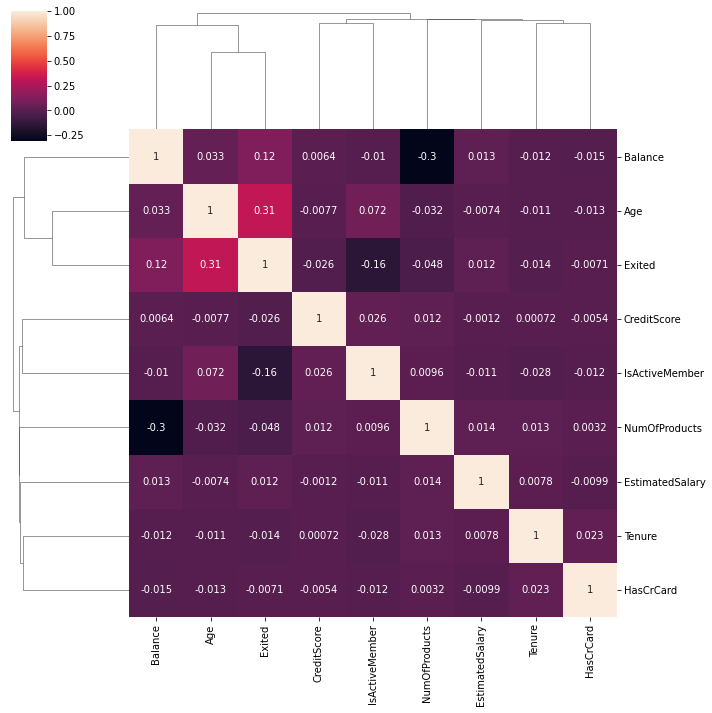

In [10]:
sns.clustermap(data=bank_num.corr(), annot=True)

In [11]:
pp.detected_highly_corr(bank_num, bank_num.columns[-1]).head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,42.0,2,0.00,1,1,1,101348.88,1
1,608.0,41.0,1,83807.86,1,0,1,112542.58,0
2,502.0,42.0,8,159660.80,3,1,0,113931.57,1
3,699.0,39.0,1,0.00,2,0,0,93826.63,0
4,850.0,43.0,2,125510.82,1,1,1,79084.10,0


In [12]:
bank_num.corr()['Exited'].abs().sort_values(ascending=False)

Exited             1.000000
Age                0.312436
IsActiveMember     0.156128
Balance            0.118533
NumOfProducts      0.047820
CreditScore        0.026455
Tenure             0.014001
EstimatedSalary    0.012097
HasCrCard          0.007138
Name: Exited, dtype: float64

### Skewness

In [13]:
pp.skewness_calc(bank_num[non_binary_col], threshold=80, transform=True).head()

-Skewness Columns:  []


,CreditScore,Age,Tenure,Balance,EstimatedSalary
0,619.0,42.0,2,0.00,101348.88
1,608.0,41.0,1,83807.86,112542.58
2,502.0,42.0,8,159660.80,113931.57
3,699.0,39.0,1,0.00,93826.63
4,850.0,43.0,2,125510.82,79084.10


### Multi.Collinearity

In [14]:
pp.multi_colinearity(bank_num[non_binary_col], threshold=50, drop_cols=False)

,feature,VIF
0,CreditScore,16.047611
1,Age,12.894583
4,EstimatedSalary,3.853735
2,Tenure,3.825728
3,Balance,2.466915


### Encoding

In [15]:
nominal_cat_train = pp.encoding_nominal_cat(df_train=bank_cat, nominal_cats=['Geography'])
ordinal_cat_train = pp.encoding_ordinal_cat(df_train=bank_cat, ordinal_cats=['Gender'])

In [16]:
final_train_cat = pd.merge(nominal_cat_train, ordinal_cat_train, left_index=True, right_index=True)

### merge Numeric with Categorical after encoding

In [136]:
bank_final = pd.merge(final_train_cat, bank_num, left_index=True, right_index=True)

In [137]:
bank_final.head()

,France,Germany,Spain,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1.0,0.0,0.0,0,619.0,42.0,2,0.00,1,1,1,101348.88,1
1,0.0,0.0,1.0,0,608.0,41.0,1,83807.86,1,0,1,112542.58,0
2,1.0,0.0,0.0,0,502.0,42.0,8,159660.80,3,1,0,113931.57,1
3,1.0,0.0,0.0,0,699.0,39.0,1,0.00,2,0,0,93826.63,0
4,0.0,0.0,1.0,0,850.0,43.0,2,125510.82,1,1,1,79084.10,0


### Balanced or not?

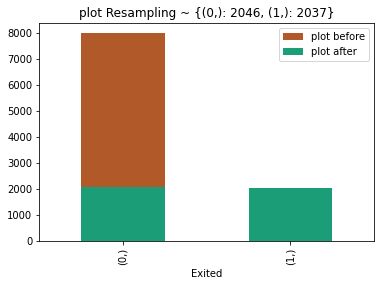

In [138]:
bank_final = pp.handling_binary_imbalance(bank_final, columns_name=['Exited'], unique_values=[0, 1], frac_list=[0.257, 1], random_state=2020)

### Split Data to Train and Validation

In [141]:
X = bank_final.iloc[:, :-1]
y = bank_final.iloc[:, -1].values.reshape(-1, 1)

In [142]:
X_train, X_vld, y_train, y_vld = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

### Shapiro Test

In [143]:
X.shape

(4083, 12)

In [144]:
pp.shapiro_test(X_train, n_sample=500)
pp.shapiro_test(X_vld, n_sample=500)

+ Column '['CreditScore']' is normally distributed (std)
- Column '['France', 'Germany', 'Spain', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']' is 'not' normally distributed (minmax)
+ Column '['CreditScore']' is normally distributed (std)
- Column '['France', 'Germany', 'Spain', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']' is 'not' normally distributed (minmax)


### Scaling

In [145]:
minmax = ['France', 'Germany', 'Spain', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
std = ['CreditScore']
X_train[minmax], X_vld[minmax] = pp.scaling(X_train[minmax], X_vld[minmax], scaling_type='minmax')
X_train[std], X_vld[std] = pp.scaling(X_train[std], X_vld[std], scaling_type='standard')

### Modeling

In [146]:
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score, recall_score
def plot_confusion_matrix(y_true, y_pred, y_Label=None):
    column=[f'Predicted {label}' for label in y_Label]
    indices=[f'Actual {label}' for label in y_Label]
    table=pd.DataFrame(confusion_matrix(y_true, y_pred), columns=column, index=indices)
    
    return sns.heatmap(table,  fmt='d', annot = True)

def model_metrics(test_y, pred_y):
    model_acc = accuracy_score(test_y, pred_y)
    f_score = f1_score(test_y, pred_y, average='macro')
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    print('---------------------------------------------------------------------------')
    print('| Accuracy: %.4f | f1 Score: %.4f | precision: %.4f | recall: %.4f |' % (model_acc, f_score, precision, recall))
    print('---------------------------------------------------------------------------')

#### Logistic Regression

In [187]:
# LogisticRegression(penalty={l1, l2, elasticnet}, C=1, class_weight=None, solver = {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
for i in np.arange(0.1, 1.1, 0.1):
    log = LogisticRegression(penalty='l1', solver='saga', max_iter=120, C=i, class_weight='balanced')
    log.fit(X_train, y_train)

    y_pred = log.predict(X_vld)
    print(i, model_metrics(y_vld, y_pred))

---------------------------------------------------------------------------
| Accuracy: 0.7124 | f1 Score: 0.7124 | precision: 0.7125 | recall: 0.7125 |
---------------------------------------------------------------------------
0.1 None
---------------------------------------------------------------------------
| Accuracy: 0.7173 | f1 Score: 0.7173 | precision: 0.7173 | recall: 0.7173 |
---------------------------------------------------------------------------
0.2 None
---------------------------------------------------------------------------
| Accuracy: 0.7136 | f1 Score: 0.7136 | precision: 0.7136 | recall: 0.7136 |
---------------------------------------------------------------------------
0.30000000000000004 None
---------------------------------------------------------------------------
| Accuracy: 0.7124 | f1 Score: 0.7124 | precision: 0.7124 | recall: 0.7124 |
---------------------------------------------------------------------------
0.4 None
--------------------------------

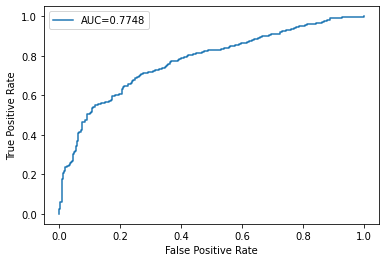

In [167]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = log.predict_proba(X_vld)[:, 1]

fpr, tpr, thresholds = roc_curve(y_vld, y_pred_proba)
auc = roc_auc_score(y_vld, y_pred_proba)

#create ROC curve showing in the bottom the AUC curve
plt.plot(fpr,tpr,label="AUC="+str(round(auc,4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=2)
plt.show()

In [168]:
thresholds[np.where(tpr >= 0.7)[0][0]]

0.5175942707733955

#### Logistic Regression from Scratch

In [169]:
def z(X, theta):
    return np.dot(X, theta)

def sigmoid(z):
    return 1/(1 + np.power(np.e, -z))

def cost(X, y, theta):
    z = np.dot(X,theta)
    cost0 = y.T.dot(np.log(sigmoid(z)))
    cost1 = (1-y).T.dot(np.log(1-sigmoid(z)))
    cost = -((cost1 + cost0))/len(y) 
    return cost

def fit(X, y, alpha=0.001, bias=True, max_iter=100):
    m, n= X.shape
    theta = np.zeros((n, 1))
    
    if bias:
        X = np.concatenate((np.ones((m, 1)), X), axis=1)
        theta = np.zeros((n+1, 1))
        m, n= X.shape
        
    for _ in range(max_iter):
        zz = z(X, theta)
        theta = theta - alpha * np.dot(X.T, sigmoid(zz) - y.reshape(-1, 1))
    return theta


def predict(X, theta, bias=True, threshold = 0.5):
    m, n= X.shape
    
    if bias:
        X = np.concatenate((np.ones((m, 1)), X), axis=1)
    
    zz = z(X, theta)
    preds = []
    for i in sigmoid(zz):
        if i > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return preds

In [186]:
thetas = fit(X_train, y_train, alpha=0.0009, max_iter=120)
y_pred = predict(X_vld, thetas, threshold=0.51)
model_metrics(y_vld, y_pred)

---------------------------------------------------------------------------
| Accuracy: 0.7148 | f1 Score: 0.7147 | precision: 0.7148 | recall: 0.7147 |
---------------------------------------------------------------------------


<AxesSubplot:>

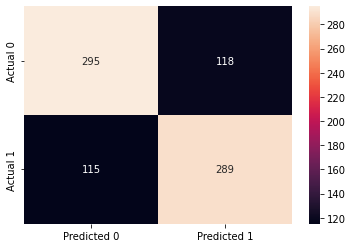

In [190]:
plot_confusion_matrix(y_vld, y_pred, [0, 1])

In [201]:
conf_matrix = pd.DataFrame(confusion_matrix(y_vld, y_pred).T, index=['Predicted_not_churn', 'Predicted_churn'], columns=['Actual_not_churn','Actual_churn'])
conf_matrix

# tp+fn
total_Actual_not_churn = np.sum(conf_matrix, axis=0)[0]
# fp+tn
total_Actual_churn = np.sum(conf_matrix, axis=0)[1]
#tp+fp
total_Predicted_not_churn = np.sum(conf_matrix, axis=1)[0]
#fn+tn
total_Predicted_churn = np.sum(conf_matrix, axis=1)[1]


# Precision
precision_churn = conf_matrix.iloc[1,1] / total_Predicted_churn
precision_not_churn = conf_matrix.iloc[0,0] / total_Predicted_not_churn

# Recall
recall_churn = conf_matrix.iloc[1,1]/total_Actual_churn
recall_not_churn = conf_matrix.iloc[0,0]/total_Actual_not_churn

# F Score
f_score_churn = 2 * (precision_churn * recall_churn)/(precision_churn+recall_churn)
f_score_not_churn = 2 * (precision_not_churn * recall_not_churn)/(precision_not_churn+recall_not_churn)

In [202]:
print('total_Actual_not_churn: ',total_Actual_not_churn)
print('total_Actual_churn: ',total_Actual_churn)
print('total_Predicted_not_churn: ',total_Predicted_not_churn)
print('total_Predicted_churn: ',total_Predicted_churn)
print('----------------------------------------------------')
print('precision_not_churn: ', precision_not_churn)
print('precision_churn: ', precision_churn)
print('recall_not_churn: ', recall_not_churn)
print('recall_churn: ', recall_churn)
print('F1_score_not_churn: ', f_score_not_churn)
print('F1_score_churn: ', f_score_churn)

total_Actual_not_churn:  413
total_Actual_churn:  404
total_Predicted_not_churn:  410
total_Predicted_churn:  407
----------------------------------------------------
precision_not_churn:  0.7195121951219512
precision_churn:  0.7100737100737101
recall_not_churn:  0.7142857142857143
recall_churn:  0.7153465346534653
F1_score_not_churn:  0.7168894289185905
F1_score_churn:  0.7127003699136869


#### $$===============================================$$

#### SVM

In [204]:
CC = [0.1, 0.6, 1, 5, 10, 30, 50, 100]
GG = ['auto', 'scale', 0.01, 0.04, 0.001, 0.0006, 0.0001]
DD = [1, 2, 3, 4, 5, 6]

##### kernel poly

In [207]:
# C=1, kernel={'linear', 'poly', 'rbf'}, degree=3, gamma={'scale', 'auto'}, class_weight=None
#linear -> C[0.1, 0.6, 1, 5, 10, 30, 50, 100]
# poly -> C , gamma, degree[1, 2, 3, 4, 5, 6]
# rbf -> C, gamma['auto', 'scale', 0.01, 0.04, 0.001, 0.0006, 0.0001]
for c in CC:
    for g in GG:
        for d in DD:
            svm = SVC(kernel='poly', C=c, gamma=g, degree=d, class_weight='balanced')
            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_vld)
            print(c,g,d, model_metrics(y_vld, y_pred))

---------------------------------------------------------------------------
| Accuracy: 0.7001 | f1 Score: 0.6996 | precision: 0.7008 | recall: 0.6997 |
---------------------------------------------------------------------------
0.1 auto 1 None
---------------------------------------------------------------------------
| Accuracy: 0.6585 | f1 Score: 0.6584 | precision: 0.6591 | recall: 0.6588 |
---------------------------------------------------------------------------
0.1 auto 2 None
---------------------------------------------------------------------------
| Accuracy: 0.6353 | f1 Score: 0.6268 | precision: 0.6518 | recall: 0.6370 |
---------------------------------------------------------------------------
0.1 auto 3 None
---------------------------------------------------------------------------
| Accuracy: 0.6328 | f1 Score: 0.6246 | precision: 0.6485 | recall: 0.6345 |
---------------------------------------------------------------------------
0.1 auto 4 None
--------------------

In [210]:
svm = SVC(kernel='poly', C=50, gamma='scale', degree=2, class_weight='balanced')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_vld)
model_metrics(y_vld, y_pred)

---------------------------------------------------------------------------
| Accuracy: 0.7711 | f1 Score: 0.7708 | precision: 0.7720 | recall: 0.7708 |
---------------------------------------------------------------------------


In [218]:
CCC = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


##### kernel linear

In [219]:
for c in CCC:
    svm = SVC(kernel='linear', C=c, class_weight='balanced')
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_vld)
    print(c, model_metrics(y_vld, y_pred))

---------------------------------------------------------------------------
| Accuracy: 0.7087 | f1 Score: 0.7087 | precision: 0.7087 | recall: 0.7087 |
---------------------------------------------------------------------------
1.0 None
---------------------------------------------------------------------------
| Accuracy: 0.7185 | f1 Score: 0.7184 | precision: 0.7184 | recall: 0.7184 |
---------------------------------------------------------------------------
1.0 None
---------------------------------------------------------------------------
| Accuracy: 0.7197 | f1 Score: 0.7196 | precision: 0.7197 | recall: 0.7196 |
---------------------------------------------------------------------------
1.0 None
---------------------------------------------------------------------------
| Accuracy: 0.7173 | f1 Score: 0.7172 | precision: 0.7172 | recall: 0.7172 |
---------------------------------------------------------------------------
1.0 None
------------------------------------------------

In [220]:
svm = SVC(kernel='linear', C=0.3, class_weight='balanced')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_vld)
print(c, model_metrics(y_vld, y_pred))

---------------------------------------------------------------------------
| Accuracy: 0.7197 | f1 Score: 0.7196 | precision: 0.7197 | recall: 0.7196 |
---------------------------------------------------------------------------
99 None


##### kernel rbf

In [221]:
for c in CCC:
    for g in GG:
        svm = SVC(kernel='rbf', C=c, gamma=g, class_weight='balanced')
        svm.fit(X_train, y_train)

        y_pred = svm.predict(X_vld)
        print(c,g, model_metrics(y_vld, y_pred))

---------------------------------------------------------------------------
| Accuracy: 0.6965 | f1 Score: 0.6964 | precision: 0.6964 | recall: 0.6964 |
---------------------------------------------------------------------------
0.1 auto None
---------------------------------------------------------------------------
| Accuracy: 0.6879 | f1 Score: 0.6879 | precision: 0.6881 | recall: 0.6880 |
---------------------------------------------------------------------------
0.1 scale None
---------------------------------------------------------------------------
| Accuracy: 0.6793 | f1 Score: 0.6751 | precision: 0.6869 | recall: 0.6781 |
---------------------------------------------------------------------------
0.1 0.01 None
---------------------------------------------------------------------------
| Accuracy: 0.6940 | f1 Score: 0.6932 | precision: 0.6951 | recall: 0.6935 |
---------------------------------------------------------------------------
0.1 0.04 None
---------------------------

In [342]:
svm = SVC(kernel='rbf', C=72, gamma='auto', class_weight='balanced')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_vld)
model_metrics(y_vld, y_pred)

---------------------------------------------------------------------------
| Accuracy: 0.7748 | f1 Score: 0.7741 | precision: 0.7770 | recall: 0.7743 |
---------------------------------------------------------------------------


##### C vs F1 with Train Data with rbf

In [287]:
f1_list_train = []
c_list = list(np.arange(1, 100, 1))
for c in c_list:
    svm = SVC(kernel='rbf', C=c, gamma='auto', class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_train)
    f1_list_train.append(f1_score(y_train, y_pred))

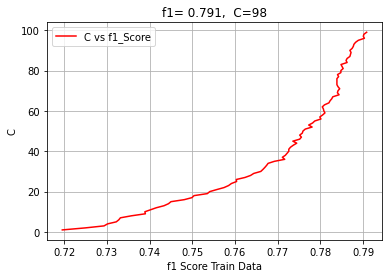

In [288]:
plt.plot(f1_list_train, c_list, c='r', label='C vs f1_Score')
plt.legend()
plt.grid()
plt.title('f1= '+str(round(max(f1_list_train),3)) +',  C='+str(98))
plt.ylabel('C')
plt.xlabel('f1 Score Train Data');

##### C vs F1 with Validation Data with rbf

In [289]:
f1_list_vld = []
c_list = list(np.arange(1, 100, 1))
for c in c_list:
    svm = SVC(kernel='rbf', C=c, gamma='auto', class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_vld)
    f1_list_vld.append(f1_score(y_vld, y_pred))

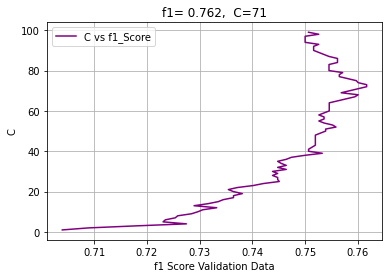

In [290]:
plt.plot(f1_list_vld, c_list, c='purple', label='C vs f1_Score')
plt.legend()
plt.grid()
plt.title('f1= '+str(round(max(f1_list_vld),3)) +',  C='+str(71))
plt.ylabel('C')
plt.xlabel('f1 Score Validation Data');

##### gamma vs F1 with Train Data with rbf

In [328]:
f1_list_train = []
gamma_list = ['scale','auto', 0.1, 0.2, 0.3, 0.4, 0.7, 0.9, 0.01, 0.04, 0.07, 0.001, 0.004, 0.007, 0.009, 1]
for g in gamma_list:
    svm = SVC(kernel='rbf', gamma=g, class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_train)
    f1_list_train.append(f1_score(y_train, y_pred))

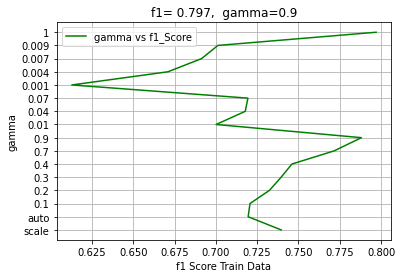

In [335]:
plt.plot(f1_list_train, gamma_list, c='r', label='gamma vs f1_Score')
plt.legend()
plt.grid()
plt.title('f1= '+str(round(max(f1_list_train),3)) +',  gamma=0.9')
plt.ylabel('gamma')
plt.xlabel('f1 Score Train Data');

In [333]:
svm = SVC(kernel='rbf', gamma=0.9, class_weight='balanced')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_train)
f1_score(y_train, y_pred)

0.7880521131236098

##### gamma vs F1 with Validation Data with rbf

In [321]:
f1_list_vld = []
for g in gamma_list:
    svm = SVC(kernel='rbf', gamma=g, class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_vld)
    f1_list_vld.append(f1_score(y_vld, y_pred))

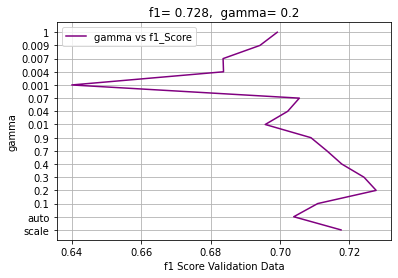

In [327]:
plt.plot(f1_list_vld, gamma_list, c='purple', label='gamma vs f1_Score')
plt.legend()
plt.grid()
plt.title('f1= '+str(round(max(f1_list_vld),3)) +',  gamma= 0.2')
plt.ylabel('gamma')
plt.xlabel('f1 Score Validation Data');

In [340]:
svm = SVC(kernel='rbf', gamma=0.2, C=72, class_weight='balanced')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_vld)
f1_score(y_vld, y_pred)

0.7509386733416771

### Confusing Matrix
##### Count of TN=$C_{0,0}$ , FN=$C_{1,0}$ , TP=$C_{1,1}$ and FP=$C_{0,1}$.
##### Accuracy=$C_{1,1}$/($C_{1,1}$+$C_{0,1}$)
##### Precision=$C_{1,1}$/($C_{1,1}$+$C_{0,1}$)
##### Recall=$C_{1,1}$/($C_{1,1}$+$C_{1,0}$)
##### F1 Score= ${2*} C_{1,1}$ / (2*$C_{1,1}$+$C_{0,1}$+$C_{1,0}$)
##### Confusion Matrix
##### [[$C_{0,0}$ $C_{0,1}$],
##### [$C_{1,0}$ $C_{1,1}$]]

In [347]:
conf_matrix = pd.DataFrame(confusion_matrix(y_vld, y_pred).T, index=['Predicted_not_churn', 'Predicted_churn'], columns=['Actual_not_churn','Actual_churn'])
conf_matrix

# tp+fn
total_Actual_not_churn = np.sum(conf_matrix, axis=0)[0]
# fp+tn
total_Actual_churn = np.sum(conf_matrix, axis=0)[1]
#tp+fp
total_Predicted_not_churn = np.sum(conf_matrix, axis=1)[0]
#fn+tn
total_Predicted_churn = np.sum(conf_matrix, axis=1)[1]


# Precision
precision_churn = conf_matrix.iloc[1,1] / total_Predicted_churn
precision_not_churn = conf_matrix.iloc[0,0] / total_Predicted_not_churn

# Recall
recall_churn = conf_matrix.iloc[1,1]/total_Actual_churn
recall_not_churn = conf_matrix.iloc[0,0]/total_Actual_not_churn

# F Score
f_score_churn = 2 * (precision_churn * recall_churn)/(precision_churn+recall_churn)
f_score_not_churn = 2 * (precision_not_churn * recall_not_churn)/(precision_not_churn+recall_not_churn)

In [348]:
print('total_Actual_not_churn: ',total_Actual_not_churn)
print('total_Actual_churn: ',total_Actual_churn)
print('total_Predicted_not_churn: ',total_Predicted_not_churn)
print('total_Predicted_churn: ',total_Predicted_churn)
print('----------------------------------------------------')
print('precision_not_churn: ', precision_not_churn)
print('precision_churn: ', precision_churn)
print('recall_not_churn: ', recall_not_churn)
print('recall_churn: ', recall_churn)
print('F1_score_not_churn: ', f_score_not_churn)
print('F1_score_churn: ', f_score_churn)

total_Actual_not_churn:  413
total_Actual_churn:  404
total_Predicted_not_churn:  449
total_Predicted_churn:  368
----------------------------------------------------
precision_not_churn:  0.755011135857461
precision_churn:  0.7989130434782609
recall_not_churn:  0.8208232445520581
recall_churn:  0.7277227722772277
F1_score_not_churn:  0.7865429234338748
F1_score_churn:  0.7616580310880828
